In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The goal is to train a random forest classifier to detect smiling people in a given picture. 

- We have a labeled dataset which contains 800 pictures of smiling faces and non smiling faces (50/50).

# Load data

In [284]:
import pickle
X, y = pickle.load(open("dataset.pkl", "rb"))

Let's print some pictures:

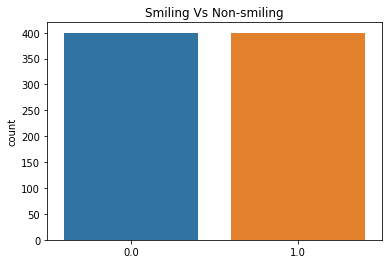

In [280]:
plt.figure
sns.countplot(pd.Series(y))
plt.title('Smiling Vs Non-smiling')
plt.show()

The dataset is perfectly balanced.

In [276]:
def plot_img(idx, x, y):
    plt.imshow(x[idx])
    if int(y[idx])==0:
        plt.title('not smiling')
    else:
        plt.title('Smiling')

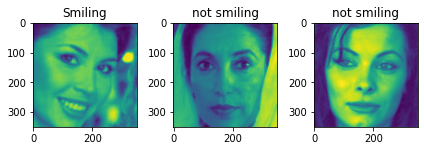

In [277]:
plt.figure()
plt.subplot(1,3,1)
plot_img(4, X, y)

plt.subplot(1,3,2)
plot_img(5, X, y)
plt.tight_layout()


plt.subplot(1,3,3)
plot_img(6, X, y)
plt.tight_layout()
plt.show()

plt.show()

As you can see from the pictures above, the lips can be a good indicator for smiling. To extract the lips landmark we will use `Face_recognition` API.

In [22]:
import face_recognition

landmarks = face_recognition.face_landmarks(X_train[0])

In [291]:
def get_lip_landmark(X, y):
    X_landmark = []
    mask = []
    progress = 0
    for image in X:
        # on prend le premier element car chaque image contient uniquement un seul visage
        landmarks = face_recognition.face_landmarks(image)
        if len(landmarks) > 0:
            landmarks = landmarks[0]
            mask.append(True)
        else:
            # dans certaine image, on n'arrive pas à detecter les landmarks
            mask.append(False)
            continue
        X_landmark_img = []
        for top_lip_x, top_lip_y in landmarks['top_lip']:
            X_landmark_img.extend([top_lip_x, top_lip_y])

        for bottom_lip_x, bottom_lip_y in landmarks['bottom_lip']:
            X_landmark_img.extend([bottom_lip_x, bottom_lip_y])
        X_landmark.append(X_landmark_img)
        progress += 1
        print(f"Progress ...[{progress*100/len(X):.2f}%]", end='\r')
        
    return X_landmark ,y[mask]

In [292]:
from sklearn.model_selection import train_test_split

# get lip landmarks
X_land, y_land = get_lip_landmark(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_land, y_land, stratify=y_land, test_size=0.2, random_state=0)

In [293]:
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=2,ccp_alpha = 0.02)

rf2.fit(X_train_landmark, y_train_landmark)

RandomForestClassifier(ccp_alpha=0.02, max_depth=6, min_samples_leaf=4)

In [294]:
from sklearn.metrics import classification_report
print(classification_report(y_train_landmark, rf2.predict(X_train_landmark)))
print(classification_report(y_test_landmark, rf2.predict(X_test_landmark)))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       318
         1.0       0.97      0.97      0.97       311

    accuracy                           0.97       629
   macro avg       0.97      0.97      0.97       629
weighted avg       0.97      0.97      0.97       629

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98        80
         1.0       0.99      0.96      0.97        80

    accuracy                           0.97       160
   macro avg       0.98      0.98      0.97       160
weighted avg       0.98      0.97      0.97       160



In [295]:
import os.path
from os import path
import cv2

class DetectSmiling:
    '''
    Author: M. Brahim BIZANKAD
    
    Detect smiling faces
    
    parameters
    ----------
    image_path(str): path to image containg faces
    model_ml(obj): model that predicts whether a face is smiling
    detection_threshhold(float): threshold to classify a person as smiling
    
    methods
    -------
    plot_bounding_boxes: plots the image with bounding boxes and prediction result
    '''
    def __init__(self, image_path, model_ml, detection_threshhold=.5):
        self.img = self.__load_img(image_path)
        self.model_ml = model_ml
        self.detection_threshhold = detection_threshhold
        
        self.faces = self.__get_faces(self.img)
        if (self.faces) == 0:
            print('no faces have been detected')
        else:
            self.lip_landamrks = self.__get_lip_landmark()
 
    def __get_faces(self, image):
        # returns list of faces coordinates detected on the picture
        faces = face_recognition.face_locations(image)
        if len(faces) > 0:
            return faces
        else:
            return None
    
    def __load_img(self, image_path):
        
        if path.exists(image_path):
            return plt.imread(image_path)
        else:
            print('incorrect path!')
    
    
    def __predict_proba(self, face_landmark):
        return self.model_ml.predict_proba(face_landmark.reshape(1, -1))[:,1][0]
    
    def __get_lip_landmark(self):
        lip_landmark = []

        for face in self.faces:
            top, right, bottom, left = face
            # zoom two times to be able to clearly detect the smile
            face_resized = cv2.resize(self.img[top:bottom, left:right], (350, 350))
            
            # 2nd zoom: check if zoom is possible
            if self.__get_faces(face_resized) is not None:
                top, right, bottom, left = self.__get_faces(face_resized)[0]
                face_resized = cv2.resize(face_resized[top:bottom, left:right], (350, 350))
            
            # extract face landmark
            face_landmark = face_recognition.face_landmarks(face_resized)
            
            # check if face recongition is able to detect landmarks
            if len(face_landmark) == 0:
                lip_landmark.append(np.zeros(48))
                continue
            
            # each resized image contains only one face 
            face_landmark = face_landmark[0]
            top_bottom_landmark = []
            for top_lip_x, top_lip_y in face_landmark['top_lip']:
                top_bottom_landmark.extend([top_lip_x, top_lip_y])

            for bottom_lip_x, bottom_lip_y in face_landmark['bottom_lip']:
                top_bottom_landmark.extend([bottom_lip_x, bottom_lip_y])

            lip_landmark.append(top_bottom_landmark)

        return lip_landmark
    
    def plot_bounding_boxes(self):
        plt.figure(figsize=(15,10))
        ax = plt.axes()
        plt.imshow(self.img)
        
        face_id = 0
        for face in self.faces:
            top, right, bottom, left = face
            
            lip_landmark = np.array(self.lip_landamrks[face_id])
            
            if (lip_landmark != np.zeros(48)).all:

                proba = self.__predict_proba(lip_landmark)
            
                if proba > self.detection_threshhold:
                    ax.annotate(f"Smiling - {proba:.2%}", (left, top-3), color='green')
                    ax.add_patch(Rectangle((left, top), 
                                         right-left, bottom - top, 
                                        fc ='none',  
                                        ec ='g', 
                                        lw = 1) ) 
                else:
                    ax.annotate(f"not smiling - {1-proba:.2%}", (left, top-3), color='red')
                    ax.add_patch(Rectangle((left, top), 
                                         right-left, bottom - top, 
                                        fc ='none',  
                                        ec ='r', 
                                        lw = 1) ) 

            face_id +=1

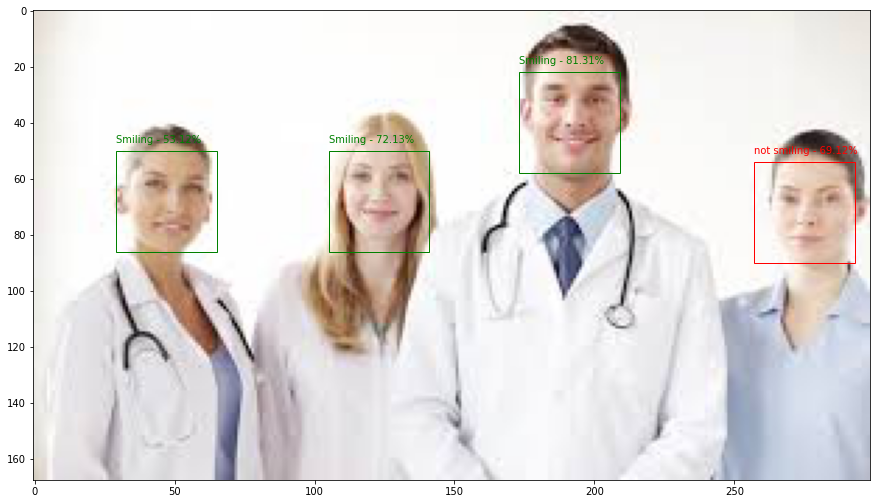

In [296]:
obj = DetectSmiling('im_test_01.jpg', rf2)
obj.plot_bounding_boxes()

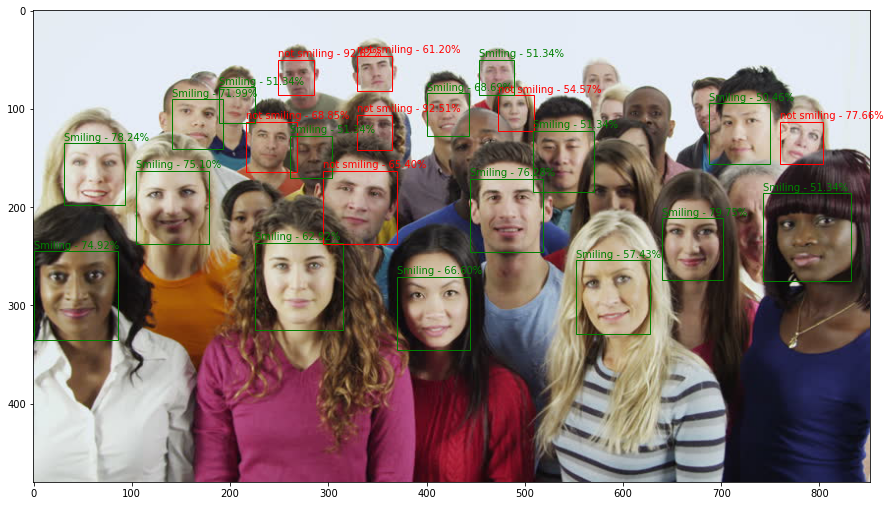

In [297]:
obj = DetectSmiling('im_test_02.jpg', rf2)
obj.plot_bounding_boxes()

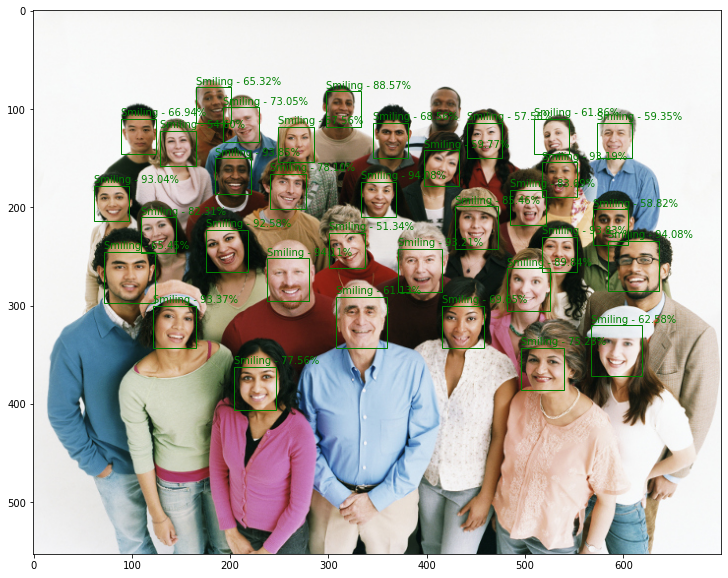

In [298]:
obj = DetectSmiling('im_test_03.jpg', rf2)
obj.plot_bounding_boxes()